<a href="https://colab.research.google.com/github/JoanChege/CHATBOT1/blob/main/Model_training3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import json
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
from keras.preprocessing.text import tokenizer_from_json



In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [25]:
# Load your data from the JSON file
with open('/content/dataset3.json') as f:
    intents = json.load(f)


# Preprocess data
stop_words = set(stopwords.words('english'))
data = []
labels = []

if intents is not None:
    lemmatizer = WordNetLemmatizer()

    for intent in intents['intents']:
        for pattern in intent['patterns']:
            # Tokenize, filter stopwords, lemmatize
            tokenized_pattern = word_tokenize(pattern)
            filtered_pattern = [word.lower() for word in tokenized_pattern if word.isalnum() and word.lower() not in stop_words]
            lemmatized_pattern = [lemmatizer.lemmatize(word) for word in filtered_pattern]

            data.append(' '.join(lemmatized_pattern))
            labels.append(intent['tag'])

# Sample print to verify preprocessing
print("Processed Data:")
for d, l in zip(data, labels):
    print(f"Pattern: {d}, Label: {l}")


Streaming output truncated to the last 5000 lines.
Pattern: lsd electric feel charging viens powering every inch body feel everything inside intensely like feel every part inside working keep body alive shiver connects everything around feel electric pulse universe easily lsd hallucination also electric sharp pattern bright colour triangle aztec like melting surface away show pattern underneath mushroom magnetic feel pull core earth everything feel grounded completely rooted feel nature pull showing vibrates gently pulling arm holding accepting fully feel childlike curious like little kitten hallucination gentle flowing wave like ebb flow pattern earth spiral especially present incredible hard try hard describe, Label:  
Pattern: solanaceae substance, Label:  
Pattern: taking break awhile, Label:  
Pattern: one inspiring thing read exactly need funny planning implement tonight start sparring, Label:  
Pattern: take sign start man along remember matter many time slip long always regain 

In [6]:
# Create a Pandas DataFrame
df = pd.DataFrame({'Patterns': data, 'Tags': labels})
df

,Patterns,Tags
0,hi,greeting
1,hey,greeting
2,anyone,greeting
3,hi,greeting
4,hello,greeting
...,...,...
5986,think absolutely need think realized therapy c...,
5987,supposed ca get head depressed sometimes suici...,
5988,med counseling sorted,
5989,deleted,


In [7]:
# Save processed data to pickle files
pickle.dump(df['Patterns'], open('data.pkl', 'wb'))
pickle.dump(df['Tags'], open('labels.pkl', 'wb'))

In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data)
sequences = tokenizer.texts_to_sequences(data)

word_index = tokenizer.word_index
print(f"Number of unique words: {len(word_index)}")


Number of unique words: 10334


In [9]:
#save tokenized data in a json file
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(json.dumps(tokenizer_json))

In [36]:
# Store  index->word mappings
index_to_word = {v:k for k, v in tokenizer.word_index.items()}

def decode_sequence(seq):
    # Cast indices to integers and filter out 0 values
    seq = [int(i) for i in seq if int(i) != 0]

    # Decode the sequence
    decoded = [index_to_word[i] for i in seq]
    return ' '.join(decoded)


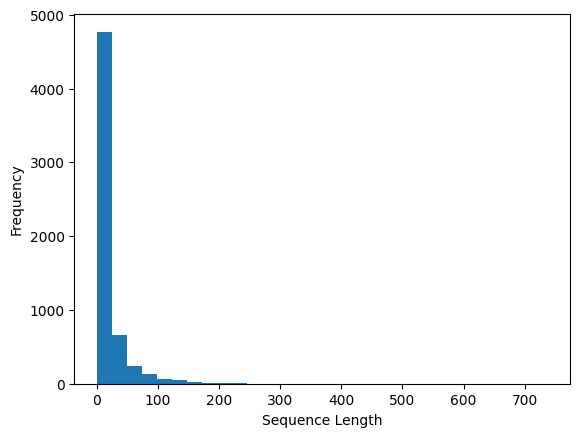

Mean sequence length: 18.115339676180938
Max sequence length: 738


In [30]:
# Calculate sequence lengths
sequence_lengths = [len(seq) for seq in sequences]

# Plot histogram
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

# Print statistics
print(f"Mean sequence length: {np.mean(sequence_lengths)}")
print(f"Max sequence length: {np.max(sequence_lengths)}")

In [31]:
# Constants for tokenization and padding
MAX_WORDS = 10334
MAX_SEQUENCE_LENGTH = 738

# Tokenize the data
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(data)
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences
sequences = tokenizer.texts_to_sequences(data)
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
max_sequence_length = max(len(seq) for seq in sequences)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
one_hot_labels = to_categorical(encoded_labels)
le = LabelEncoder()
y_encoded = le.fit_transform(labels)

num_classes = len(le.classes_)


In [32]:
# Split the data into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, one_hot_labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (4792, 738), y_train shape: (4792, 318)
X_val shape: (599, 738), y_val shape: (599, 318)
X_test shape: (600, 738), y_test shape: (600, 318)


In [13]:
#Build the bidirectional lstm model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=max_sequence_length))
model.add(Bidirectional(LSTM(units=64, activation='tanh', kernel_regularizer=l2(0.01), return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=32, activation='tanh', kernel_regularizer=l2(0.01))))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [14]:
# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 738, 100)          1033600   
                                                                 
 bidirectional (Bidirection  (None, 738, 128)          84480     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 738, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4

In [16]:
hist = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
75/75 [==============================] - 29s 272ms/step - loss: 5.6074 - accuracy: 0.8203 - val_loss: 2.6282 - val_accuracy: 0.8664
Epoch 2/20
75/75 [==============================] - 15s 202ms/step - loss: 1.8875 - accuracy: 0.8992 - val_loss: 1.6282 - val_accuracy: 0.8664
Epoch 3/20
75/75 [==============================] - 15s 204ms/step - loss: 1.3404 - accuracy: 0.8992 - val_loss: 1.4282 - val_accuracy: 0.8664
Epoch 4/20
75/75 [==============================] - 14s 187ms/step - loss: 1.1826 - accuracy: 0.8992 - val_loss: 1.3950 - val_accuracy: 0.8664
Epoch 5/20
75/75 [==============================] - 12s 160ms/step - loss: 1.0865 - accuracy: 0.8992 - val_loss: 1.3497 - val_accuracy: 0.8664
Epoch 6/20
75/75 [==============================] - 12s 159ms/step - loss: 1.0517 - accuracy: 0.8992 - val_loss: 1.3485 - val_accuracy: 0.8664
Epoch 7/20
75/75 [==============================] - 10s 133ms/step - loss: 1.0192 - accuracy: 0.8992 - val_loss: 1.3696 - val_accuracy: 0.8664

In [17]:
def plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

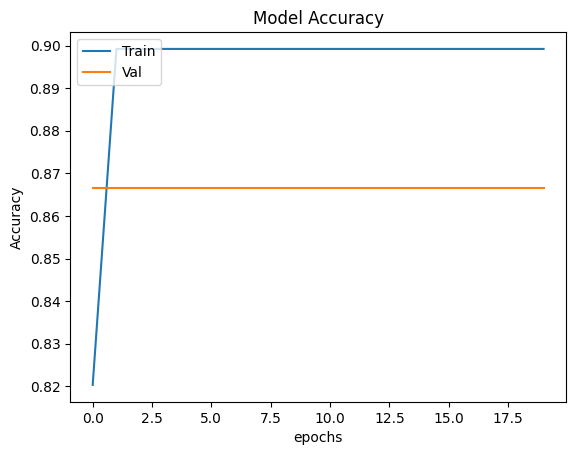

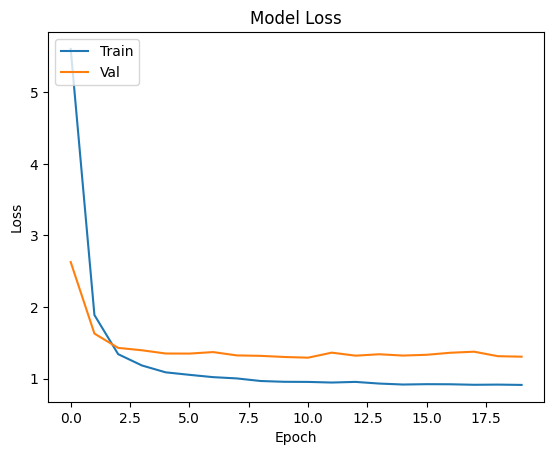

In [18]:
plot(hist)

USE BLEU SCORE

In [19]:
model.save("chatbot_model.h5")
print('Done')

Done


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
#Generate predictions
y_pred = model.predict(X_test)


19/19 [==============================] - 1s 42ms/step


In [37]:
# Decode predictions
y_pred = [decode_sequence(pred) for pred in y_pred]

In [42]:
bleu_scores = []
brevity_penalties = []

for actual, predicted in zip(y_test, y_pred):
    bleu = sentence_bleu([actual], predicted)
    bleu_scores.append(bleu)

    reference_length = len(actual)
    predicted_length = len(predicted)

    # Calculate brevity penalty
    if predicted_length < reference_length:
        bp = 1.0  # Less harsh penalty for shorter predictions
    else:
        bp = np.exp(1 - reference_length / predicted_length)

    brevity_penalties.append(bp)

print('BLEU Score:', np.mean(bleu_scores))
print('BP:', np.mean(brevity_penalties))


BLEU Score: 0.0
BP: 1.0
